# Directly importing a small chunk of dataset from the website and making a time series problem out of it with 4 features (including the lagged/previous velocities) and 1 lable (velocity).
# Introduced a new coloum of previous velocity by shifting the target variable to create a lag (storing the velocity of previous time step).
# Tried to use an autoregressive LSTM model and make some future velocity predictions.

In [95]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '5,6'
import os
os.environ["CUDA_VISIBLE_DEVICES"]="5,6"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [96]:
# Using seaborn for pairplot.
!pip install -q seaborn
!pip install -q tensorflow

In [97]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

print(tf.__version__)

2.14.0


In [98]:
# Defining columns to use
columns_to_use = ["global_x", "global_y", "v_vel", "v_acc", "global_time"] #using just 4 of them

# Defining chunk size for reading data
chunk_size = 100

# Initializing an empty list to store data chunks
data_chunks = []

for chunk in pd.read_csv("https://data.transportation.gov/resource/8ect-6jqj.csv", 
                         chunksize=chunk_size, usecols=columns_to_use):
    data_chunks.append(chunk)

# Concatenate data chunks into a single DataFrame
velocity_dataset = pd.concat(data_chunks, ignore_index=True)

# trajectory_dataset = pd.read_csv(
#     "https://data.transportation.gov/resource/8ect-6jqj.csv")

#   names=["Vehicle_ID", "Frame_Id", "Total_Frames", "Global_Time", "Local_X",
#            "Local_Y", "Global_X", "Global_Y", "v_length", "v_Width", "v_Vel", 
#            "v_Acc", "Lane_ID", "O_Zone", "D_Zone", "Int_ID", "Section_ID", "Direction",
#            "Movement", "Preceding", "Following", "Space_Headway", "Time_Headway", "Location"]

In [99]:
velocity_dataset.shape

(1000, 5)

In [100]:
velocity_dataset.head()

,global_time,global_x,global_y,v_vel,v_acc
0,1163368300,2230502.921,1375532.938,33.96,0.00
1,1163368200,2230503.114,1375537.934,33.96,0.00
2,1163368100,2230502.731,1375540.951,33.96,0.00
3,1163368000,2230502.906,1375544.692,33.96,10.82
4,1163051100,2230518.568,1375546.762,0.25,-4.89


In [101]:
velocity_dataset_sorted = velocity_dataset.sort_values(by='global_time')

In [102]:
velocity_dataset_sorted

,global_time,global_x,global_y,v_vel,v_acc
434,1163034800,2230519.322,1375566.277,17.29,0.0
503,1163034900,2230519.899,1375568.256,17.29,0.0
553,1163035000,2230519.957,1375569.755,17.29,0.0
710,1163035100,2230519.535,1375571.773,17.29,0.0
949,1163035200,2230520.612,1375573.733,17.29,0.0
...,...,...,...,...,...
528,1163849900,2230532.048,1375568.927,25.71,0.0
643,1163850000,2230532.204,1375571.494,25.71,0.0
563,1163850000,2230520.798,1375569.938,37.39,0.0
966,1163850100,2230532.360,1375574.060,25.71,0.0


In [103]:
# Shift the target variable to create a lag
velocity_dataset_sorted['v_vel_lagged'] = velocity_dataset_sorted['v_vel'].shift(1)

# Drop the first row since it will have NaN in the lagged column
velocity_dataset_sorted = velocity_dataset_sorted.dropna()

In [104]:
velocity_dataset_sorted

,global_time,global_x,global_y,v_vel,v_acc,v_vel_lagged
503,1163034900,2230519.899,1375568.256,17.29,0.0,17.29
553,1163035000,2230519.957,1375569.755,17.29,0.0,17.29
710,1163035100,2230519.535,1375571.773,17.29,0.0,17.29
949,1163035200,2230520.612,1375573.733,17.29,0.0,17.29
99,1163036300,2230519.819,1375553.248,25.79,0.0,17.29
...,...,...,...,...,...,...
528,1163849900,2230532.048,1375568.927,25.71,0.0,37.39
643,1163850000,2230532.204,1375571.494,25.71,0.0,25.71
563,1163850000,2230520.798,1375569.938,37.39,0.0,25.71
966,1163850100,2230532.360,1375574.060,25.71,0.0,37.39


In [105]:
input_features = ["global_x", "global_y", "v_acc", "v_vel_lagged"]
output_labels = ["v_vel"]

input_dataset = velocity_dataset_sorted[input_features]
output_dataset = velocity_dataset_sorted[output_labels]

# Split the dataset into training and test sets (80-20 split)
train_features, test_features, train_labels, test_labels = train_test_split(input_dataset, output_dataset, test_size=0.2, random_state=42)

# # Print the shape of training and test sets
# print("Train Features Shape:", train_features.shape)
# print("Train Labels Shape:", train_labels.shape)
# print("Test Features Shape:", test_features.shape)
# print("Test Labels Shape:", test_labels.shape)

In [106]:
# Normalize the features
feature_normalizer = tf.keras.layers.Normalization(axis=-1)
feature_normalizer.adapt(np.array(train_features))
print("Feature Normalizer Mean: ", feature_normalizer.mean.numpy())

# Normalize the training and test features
train_features_normalized = feature_normalizer(np.array(train_features))
test_features_normalized = feature_normalizer(np.array(test_features))

# Prepare the input and output for LSTM
X_train = []
y_train = []
X_test = []
y_test = []

# Create training data
for i in range(1, len(train_features_normalized)):
    X_train.append(train_features_normalized[i-1])
    y_train.append(train_labels.iloc[i])

# Create testing data
for i in range(1, len(test_features_normalized)):
    X_test.append(test_features_normalized[i-1])
    y_test.append(test_labels.iloc[i])

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

Feature Normalizer Mean:  [[2230521.8   1375565.5        -0.306      10.321]]


In [120]:
# Check for NaNs in training and testing data
print(f"NaNs in predictions: {np.isnan(X_train).sum()}")
print(f"NaNs in predictions: {np.isnan(X_test).sum()}")
print(f"NaNs in predictions: {np.isnan(y_train).sum()}")
print(f"NaNs in predictions: {np.isnan(y_test).sum()}")

NaNs in predictions: 0
NaNs in predictions: 0
NaNs in predictions: 0
NaNs in predictions: 0


In [107]:
# #normailizing the output layer
# label_normalizer=layers.Normalization(axis=-1)
# label_normalizer.adapt(train_labels)
# print(label_normalizer.mean.numpy())

In [108]:
# Reshape the features for LSTM [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [262]:
# Define the LSTM model
lstm_model = tf.keras.Sequential()
# Add the first LSTM layer with relu activation and input shape
lstm_model.add(tf.keras.layers.LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))

# Add a second LSTM layer with relu activation
lstm_model.add(tf.keras.layers.LSTM(64, activation='relu', return_sequences=False))  # return_sequences=False by default for last LSTM layer

# # Add a Dense layer with relu activation
# lstm_model.add(tf.keras.layers.Dense(32, activation='relu'))

lstm_model.add(tf.keras.layers.Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')


# # Early stopping callback
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# # Fit the model with early stopping
# history = lstm_model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

# Fit the model
history = lstm_model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), verbose=1)

# divide the dataset into 3 parts and then al last use the 3rd part to test the dataset (validataion dataset)
# do it after testing the model with validation dataset
#validtion = split(xtrain,ytrain, 0.2)

Epoch 1/100
25/25 [==============================] - 4s 24ms/step - loss: 258.0149 - val_loss: 286.3500
Epoch 2/100
25/25 [==============================] - 0s 12ms/step - loss: 255.0126 - val_loss: 281.0601
Epoch 3/100
25/25 [==============================] - 0s 10ms/step - loss: 247.8183 - val_loss: 266.2862
Epoch 4/100
25/25 [==============================] - 0s 8ms/step - loss: 230.2858 - val_loss: 229.4812
Epoch 5/100
25/25 [==============================] - 0s 9ms/step - loss: 199.7767 - val_loss: 186.9572
Epoch 6/100
25/25 [==============================] - 0s 9ms/step - loss: 173.4201 - val_loss: 167.5521
Epoch 7/100
25/25 [==============================] - 0s 9ms/step - loss: 161.3892 - val_loss: 166.7090
Epoch 8/100
25/25 [==============================] - 0s 8ms/step - loss: 158.3603 - val_loss: 167.1086
Epoch 9/100
25/25 [==============================] - 0s 9ms/step - loss: 157.0652 - val_loss: 167.2262
Epoch 10/100
25/25 [==============================] - 0s 9ms/step - lo

In [263]:
# Make predictions and use previous predictions as inputs for the next prediction
predictions = []
current_input = X_test[0].reshape(1, 1, X_test.shape[2])  # Start with the first test sample

for i in range(len(X_test)):
    current_pred = lstm_model.predict(current_input, verbose=0)
    if np.isnan(current_pred).any():
        print(f"NaN detected in prediction at step {i}")
        break
    predictions.append(current_pred[0])
    
    # Update the current input with the new prediction
    current_input = np.array([np.append(current_input[0][0][1:], current_pred[0])]).reshape(1, 1, -1)

# Convert predictions to the correct shape
predictions = np.array(predictions).reshape(-1, 1)

NaN detected in prediction at step 163


In [264]:
# Check for NaNs and infs in predictions
nan_count = np.isnan(predictions).sum()
inf_count = np.isinf(predictions).sum()

print(f"NaNs in predictions: {nan_count}")
print(f"Infs in predictions: {inf_count}")

NaNs in predictions: 0
Infs in predictions: 1


In [265]:
# Debugging prints to check lengths before filtering NaNs and Infs
print(f"Length of y_test before filtering NaNs: {len(y_test)}")
print(f"Length of predictions before filtering NaNs: {len(predictions)}")

# # Create combined mask to filter out NaNs and Infs
# mask = ~(np.isnan(predictions) | np.isinf(predictions))

# # Filter y_test and predictions arrays
# y_test_filtered = y_test[mask]
# predictions_filtered = predictions[mask]

# Filter out NaNs and infs from predictions
mask = ~np.isnan(predictions).flatten() & ~np.isinf(predictions).flatten()
predictions = predictions[mask]

# Ensure y_test_cleaned matches the length of predictions
y_test_filtered = y_test[:len(predictions)]
predictions_filtered = predictions[:len(predictions)]

# Debugging prints to check lengths after filtering NaNs and Infs
print(f"Length of y_test_filtered after filtering NaNs: {len(y_test_filtered)}")
print(f"Length of predictions_filtered after filtering NaNs: {len(predictions_filtered)}")

# Ensure y_test_filtered and predictions_filtered are reshaped properly
y_test_reshaped = y_test_filtered.reshape(-1, 1)
predictions_reshaped = predictions_filtered.reshape(-1, 1)

Length of y_test before filtering NaNs: 199
Length of predictions before filtering NaNs: 163
Length of y_test_filtered after filtering NaNs: 162
Length of predictions_filtered after filtering NaNs: 162


In [266]:
# Evaluate the model
mse = mean_squared_error(y_test_reshaped, predictions)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 5.29230234156925e+74


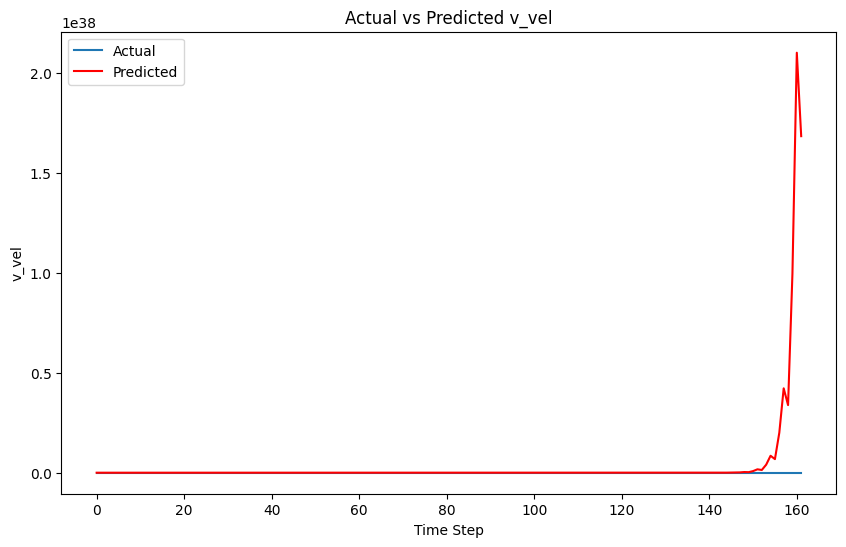

In [267]:
# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(y_test_reshaped, label='Actual')
plt.plot(predictions, label='Predicted', color='red')
plt.xlabel('Time Step')
plt.ylabel('v_vel')
plt.title('Actual vs Predicted v_vel')
plt.legend()
plt.show()

In [268]:
# Find the index of the maximum velocity
max_index = velocity_dataset['v_vel'].idxmax()

# Find the maximum velocity itself
max_velocity = velocity_dataset.loc[max_index, 'v_vel']

print(f"Maximum velocity: {max_velocity}")
print(f"Index of maximum velocity: {max_index}")

Maximum velocity: 51.3
Index of maximum velocity: 75


In [269]:
# Number of future time steps to predict
n_steps = 5

# Initialize an array to store predicted velocities
predicted_velocities = []

# Start with the last known sequence from the test data
current_input = X_test[-1].reshape(1, 1, X_test.shape[2])

# Perform autoregressive prediction for n_steps
for _ in range(n_steps):
    current_pred = lstm_model.predict(current_input, verbose=0)
    predicted_velocities.append(current_pred[0])  # Append the current prediction
    
    # Update current input with the new prediction
    current_input = np.array([np.append(current_input[0][0][1:], current_pred[0])]).reshape(1, 1, -1)

# Convert predictions to the correct shape
predicted_velocities = np.array(predicted_velocities).reshape(-1, 1)

# Print or use the predicted velocities
print("Predicted velocities for next 5 time steps using autoregressive approach:")
print(predicted_velocities)

Predicted velocities for next 5 time steps using autoregressive approach:
[[ 7.573]
 [14.019]
 [11.839]
 [48.795]
 [83.436]]
